<a href="https://colab.research.google.com/github/Jay99Sohn/GEOexosome/blob/main/GEOexosome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 0: Environment & Library Setup

# Optional: install required packages when running on Colab
# Uncomment the line below if running on Google Colab for the first time:
!pip install GEOparse imbalanced-learn shap seaborn matplotlib

# ============================================================
# Standard Library & Third-party Imports
# ============================================================

import os
import sys
import random
import json

import numpy as np
import pandas as pd
import GEOparse

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import matplotlib.pyplot as plt
import seaborn as sns
import shap

# ============================================================
# Configuration & Reproducibility
# ============================================================

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# Set visualization style for reproducible plots
sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["savefig.dpi"] = 300

print("\n" + "=" * 60)
print("ENVIRONMENT & LIBRARY SETUP")
print("=" * 60)

# ============================================================
# Environment Detection & Path Configuration
# ============================================================

if "google.colab" in sys.modules:
    from google.colab import drive
    print("[INFO] Google Colab detected. Mounting Google Drive...")
    drive.mount("/content/drive")
    base_save_path = "/content/drive/MyDrive/geoexosome_results"
    print(f"[INFO] Drive mounted. Saving results to: {base_save_path}")
else:
    base_save_path = "./geoexosome_results"
    print(f"[INFO] Local environment detected. Saving results to: {base_save_path}")

os.makedirs(base_save_path, exist_ok=True)

print("\n" + "=" * 60)
print("✓ Setup Complete")
print(f"  - Random seed: {SEED}")
print(f"  - Output path: {base_save_path}")
print("=" * 60 + "\n")



ENVIRONMENT & LIBRARY SETUP
[INFO] Google Colab detected. Mounting Google Drive...
Mounted at /content/drive
[INFO] Drive mounted. Saving results to: /content/drive/MyDrive/geoexosome_results

✓ Setup Complete
  - Random seed: 42
  - Output path: /content/drive/MyDrive/geoexosome_results



In [8]:
# ==============================================================================
# Cell 1: GEO Dataset Loading and Quality Control
# ==============================================================================
"""
Purpose:
    Download and parse the GSE39833 dataset from NCBI GEO, extract expression
    matrices, assign sample labels with full traceability, and perform
    comprehensive quality control checks.

Dataset:
    GSE39833 - Serum exosome miRNA microarray from colorectal cancer patients
    Platform: GPL14767 (Exiqon miRNA microarray)
    Samples: 99 total (11 healthy controls, 88 CRC patients)

Outputs:
    1. df_expression: DataFrame with probe-level expression values and labels
    2. mapping_df: Probe-to-miRNA mapping table
    3. label_assignment_log.csv: Full traceability of label assignments
    4. probe_to_miRNA_mapping.csv: Complete annotation mapping
    5. unmapped_probes.txt: List of probes without miRNA annotation
    6. data_quality_report.txt: Comprehensive QC summary for Methods section

Quality Controls Implemented:
    - Probe ID consistency validation across all samples
    - Missing value detection and quantification
    - Constant feature detection
    - miRNA mapping coverage assessment
    - Expression value range verification

Author: [Jungho Sohn]
Date: 2025-12-20
Version: 1.0
"""

# ==============================================================================
# STEP 1: LOAD GEO DATASET FROM NCBI
# ==============================================================================
print("\n" + "=" * 80)
print("STEP 1: LOAD GEO DATASET (GSE39833)")
print("=" * 80)

gse_id = "GSE39833"
print(f"[INFO] Downloading GEO dataset: {gse_id}")
print("[INFO] This may take 1-2 minutes depending on network speed...")

# Download and parse GEO dataset with platform annotation
# annotate_gpl=True ensures GPL annotation is included for probe-to-miRNA mapping
gse = GEOparse.get_GEO(
    geo=gse_id,
    destdir="./data",
    annotate_gpl=True
)

print(f"[INFO] Successfully loaded {gse_id}")
print(f"  - GSM samples: {len(gse.gsms)}")
print(f"  - GPL platforms: {len(gse.gpls)}")

# ==============================================================================
# STEP 2: EXTRACT EXPRESSION MATRIX AND ASSIGN SAMPLE LABELS
# ==============================================================================
"""
Label Assignment Strategy:
    Priority 1: Sample title parsing (most reliable for this dataset)
        - "hc_*" → Healthy control (label=0)
        - "crc*" → CRC patient (label=1)

    Priority 2: Metadata characteristics (fallback)
        - Cancer keywords: tnm, stage, cancer, adenocarcinoma, tumor
        - Healthy keywords: healthy, control, normal

    All label assignments are logged with their source for transparency and
    reproducibility. This log can be included in Supplementary Materials.
"""
print("\n" + "=" * 80)
print("STEP 2: EXTRACT EXPRESSION MATRIX AND ASSIGN LABELS")
print("=" * 80)

# Initialize containers for expression data and labels
samples = []           # Sample IDs (GSM accessions)
expression_rows = []   # Expression values for each sample
labels = []            # Binary labels (0=healthy, 1=CRC)
label_assignment_log = []  # Traceability log for label assignments

# Iterate through all samples in the GEO dataset
for gsm_name, gsm in gse.gsms.items():

    # Validate that expression data is available
    tbl = gsm.table
    if "VALUE" not in tbl.columns:
        print(f"[WARNING] {gsm_name} missing VALUE column. Skipping...")
        continue

    # Extract raw expression values and convert to float
    expr_vals = tbl["VALUE"].astype(float).values
    expression_rows.append(expr_vals)
    samples.append(gsm_name)

    # -------------------------------------------------------------------------
    # Label Assignment with Source Tracking
    # -------------------------------------------------------------------------
    title_list = gsm.metadata.get("title", [""])
    title = title_list[0].lower()
    label_value = None
    label_source = None

    # PRIMARY METHOD: Title-based labeling
    # This is the most reliable method for GSE39833 as samples follow
    # a consistent naming convention
    if title.startswith("hc_"):
        # Healthy control samples
        label_value = 0
        label_source = f"title (starts with 'hc_')"
    elif title.startswith("crc"):
        # CRC patient samples (includes CRC1, CRC2, CRC3a, CRC3b, CRC4 stages)
        label_value = 1
        label_source = f"title (starts with 'crc')"

    # FALLBACK METHOD: Metadata-based labeling
    # Used only if title-based labeling fails
    # This ensures robustness against potential metadata inconsistencies
    if label_value is None:
        characteristics = (
            gsm.metadata.get("characteristics_ch1", []) +
            gsm.metadata.get("characteristics_ch2", [])
        )
        chars_low = [c.lower() for c in characteristics]

        # Define keyword lists for pattern matching
        cancer_keywords = ["tnm", "stage", "cancer", "adenocarcinoma", "tumor"]
        healthy_keywords = ["healthy", "control", "normal"]

        # Check for cancer indicators in metadata
        if any(keyword in c for keyword in cancer_keywords for c in chars_low):
            label_value = 1
            label_source = "metadata (cancer-related keywords detected)"

        # Check for healthy control indicators in metadata
        elif any(keyword in c for keyword in healthy_keywords for c in chars_low):
            label_value = 0
            label_source = "metadata (healthy control keywords detected)"

    # -------------------------------------------------------------------------
    # Error Handling: Failed Label Assignment
    # -------------------------------------------------------------------------
    # If both primary and fallback methods fail, halt execution and display
    # detailed metadata to enable manual verification and rule updates
    if label_value is None:
        print("\n" + "=" * 80)
        print(f"[ERROR] Unable to determine label for sample: {gsm_name}")
        print("=" * 80)
        print(f"\nSample Metadata:")
        print(f"  - Title: {title_list}")
        print(f"  - Characteristics (ch1): {gsm.metadata.get('characteristics_ch1', [])}")
        print(f"  - Characteristics (ch2): {gsm.metadata.get('characteristics_ch2', [])}")
        print(f"  - Source: {gsm.metadata.get('source_name_ch1', ['N/A'])}")
        print(f"  - Description: {gsm.metadata.get('description', ['N/A'])}")
        print(f"\nPossible Causes:")
        print(f"  1. Unexpected metadata format (not matching expected patterns)")
        print(f"  2. Sample naming convention differs from other samples")
        print(f"  3. Ambiguous or missing label information in metadata")
        print(f"\nAction Required:")
        print(f"  Please verify the sample metadata above and update the label")
        print(f"  assignment logic in this cell accordingly.")
        print("=" * 80 + "\n")
        raise ValueError(f"Label assignment failed for {gsm_name}")

    # Record successful label assignment with source for transparency
    labels.append(label_value)
    label_assignment_log.append({
        "Sample_ID": gsm_name,
        "Label": label_value,
        "Label_Name": "Healthy_Control" if label_value == 0 else "CRC_Patient",
        "Assignment_Source": label_source,
        "Sample_Title": title_list[0]
    })

# Convert list of expression arrays to 2D numpy array
# Shape: (n_samples, n_probes)
expression_data = np.vstack(expression_rows)

print(f"[INFO] Successfully extracted expression data for {len(samples)} samples")
print(f"  - Healthy controls (label=0): {labels.count(0)}")
print(f"  - CRC patients (label=1): {labels.count(1)}")

# ==============================================================================
# STEP 3: BUILD EXPRESSION DATAFRAME WITH PROBE-LEVEL DATA
# ==============================================================================
"""
Data Structure:
    - Rows: Samples (GSM IDs)
    - Columns: Probe IDs + 'label' column
    - Values: Raw microarray intensity values

Quality Check:
    Validate that all samples have identical probe IDs in the same order.
    This is critical for ensuring data integrity in downstream analyses.
"""
print("\n" + "=" * 80)
print("STEP 3: BUILD EXPRESSION DATAFRAME")
print("=" * 80)

# Extract probe IDs from the first sample as reference
first_gsm = gse.gsms[samples[0]]
probe_ids = first_gsm.table["ID_REF"].tolist()

# -------------------------------------------------------------------------
# Quality Control: Validate Probe ID Consistency
# -------------------------------------------------------------------------
# Verify that all samples have identical probe IDs in identical order
# This check prevents silent errors from probe ID mismatches
print("[INFO] Validating probe consistency across all samples...")

# Check first 3 samples and last sample for efficiency
# Full validation is computationally expensive for large datasets
samples_to_check = samples[:3] + [samples[-1]] if len(samples) > 3 else samples
for gsm_name in samples_to_check:
    current_probes = gse.gsms[gsm_name].table["ID_REF"].tolist()

    # Check probe count
    if len(current_probes) != len(probe_ids):
        raise ValueError(
            f"[ERROR] Probe count mismatch detected in {gsm_name}\n"
            f"Expected {len(probe_ids)} probes matching {samples[0]}, "
            f"but found {len(current_probes)} probes."
        )

    # Check probe order
    if current_probes != probe_ids:
        raise ValueError(
            f"[ERROR] Probe order mismatch detected in {gsm_name}\n"
            f"Probe IDs do not match the reference sample {samples[0]}."
        )

print(f"[INFO] ✓ Probe consistency verified across {len(samples_to_check)} samples")
print(f"[INFO] All samples contain {len(probe_ids)} probes in identical order")

# Create DataFrame with probe IDs as columns and sample IDs as index
df_expression = pd.DataFrame(
    expression_data,
    columns=probe_ids,
    index=samples
)
df_expression["label"] = labels

print(f"\n[INFO] Expression DataFrame created")
print(f"  - Shape: {df_expression.shape}")
print(f"  - Samples: {df_expression.shape[0]}")
print(f"  - Probes (features): {df_expression.shape[1] - 1}")  # Excluding 'label' column
print(f"\n[INFO] Label distribution:")
print(df_expression["label"].value_counts().to_string())

# Save label assignment log for manuscript transparency
# This file should be included in Supplementary Materials
label_log_df = pd.DataFrame(label_assignment_log)
label_log_path = os.path.join(base_save_path, "label_assignment_log.csv")
label_log_df.to_csv(label_log_path, index=False)
print(f"\n[INFO] Label assignment log saved to: {label_log_path}")
print("[NOTE] Include this file in Supplementary Materials for full transparency")

# ==============================================================================
# STEP 4: BUILD PROBE-TO-miRNA MAPPING FROM PLATFORM ANNOTATION
# ==============================================================================
"""
Purpose:
    Map microarray probe IDs to known miRNA identifiers using the GPL
    platform annotation file. This enables biological interpretation of
    features in downstream analysis.

Coverage Assessment:
    Calculate and report the percentage of probes successfully mapped to
    miRNAs. Low coverage (<60%) may indicate platform compatibility issues.

Unmapped Probes:
    Probes without miRNA annotation will be excluded from downstream analysis
    to ensure all features have biological interpretability. The list of
    excluded probes is saved for transparency.
"""
print("\n" + "=" * 80)
print("STEP 4: PROBE-TO-miRNA MAPPING")
print("=" * 80)

print("[INFO] Loading platform (GPL) annotation...")

# Extract platform annotation table
gpl = list(gse.gpls.values())[0]
gpl_table = gpl.table

# Validate GPL table structure
if "ID" not in gpl_table.columns:
    raise KeyError("[ERROR] GPL table missing 'ID' column. Cannot build mapping.")

# Identify miRNA annotation column
# Look for columns containing 'mir' (case-insensitive)
mirna_cols = [c for c in gpl_table.columns if "mir" in c.lower()]

# -------------------------------------------------------------------------
# Handle Missing miRNA Annotation
# -------------------------------------------------------------------------
# Initialize coverage_pct to prevent NameError in QC section
if len(mirna_cols) == 0:
    print("[WARNING] No miRNA annotation column detected in GPL table.")
    print("[WARNING] Probe-to-miRNA mapping will be unavailable.")
    mapping_df = None
    n_mapped = 0
    n_total = len(probe_ids)
    coverage_pct = 0.0
else:
    # Use the first miRNA annotation column found
    mirna_col = mirna_cols[0]
    print(f"[INFO] Using miRNA annotation column: '{mirna_col}'")

    # Build probe-to-miRNA dictionary for fast lookup
    probe_to_mirna = dict(zip(gpl_table["ID"], gpl_table[mirna_col]))

    # Map all probe IDs to miRNA names (NaN if not found)
    mirna_names = [probe_to_mirna.get(pid, np.nan) for pid in probe_ids]

    # -------------------------------------------------------------------------
    # Calculate Mapping Coverage Statistics
    # -------------------------------------------------------------------------
    n_mapped = sum(pd.notna(m) for m in mirna_names)
    n_total = len(probe_ids)
    coverage_pct = 100.0 * n_mapped / n_total

    print(f"\n[INFO] Mapping Coverage:")
    print(f"  - Total probes: {n_total}")
    print(f"  - Successfully mapped: {n_mapped} ({coverage_pct:.1f}%)")
    print(f"  - Unmapped probes: {n_total - n_mapped} ({100 - coverage_pct:.1f}%)")

    # Create mapping DataFrame
    mapping_df = pd.DataFrame({
        "Probe_ID": probe_ids,
        "miRNA": mirna_names
    })

    # Save complete mapping table
    mapping_path = os.path.join(base_save_path, "probe_to_miRNA_mapping.csv")
    mapping_df.to_csv(mapping_path, index=False)
    print(f"\n[INFO] Probe-to-miRNA mapping saved to: {mapping_path}")

    # -------------------------------------------------------------------------
    # Save Unmapped Probes for Transparency
    # -------------------------------------------------------------------------
    # Document which probes were excluded and why
    # This justifies feature exclusion in the manuscript
    unmapped_probes = [
        probe for probe, mirna in zip(probe_ids, mirna_names)
        if pd.isna(mirna)
    ]

    if unmapped_probes:
        unmapped_path = os.path.join(base_save_path, "unmapped_probes.txt")
        with open(unmapped_path, 'w', encoding='utf-8') as f:
            f.write(f"Unmapped Probes (no miRNA annotation): {len(unmapped_probes)} total\n")
            f.write("=" * 80 + "\n\n")
            f.write("These probes will be excluded in downstream preprocessing (Cell 2) ")
            f.write("due to lack of miRNA annotation in the platform GPL file.\n\n")
            f.write("This exclusion ensures that all analyzed features have biological ")
            f.write("interpretability as known miRNAs.\n\n")
            f.write("List of unmapped probe IDs:\n")
            f.write("-" * 80 + "\n")
            for probe in unmapped_probes:
                f.write(f"{probe}\n")
        print(f"[INFO] Unmapped probes list saved to: {unmapped_path}")
        print("[NOTE] Include in Supplementary Materials to justify feature exclusion")

# ==============================================================================
# STEP 5: COMPREHENSIVE DATA QUALITY VALIDATION
# ==============================================================================
"""
Quality Control Metrics:
    1. Missing values: Count and percentage of NaN/null values
    2. Constant probes: Features with zero variance (uninformative)
    3. Expression range: Min/max values to detect outliers or errors
    4. Summary statistics: Mean, SD for manuscript reporting

Assessment Criteria:
    - Missing values: PASS if <0.01%, WARNING if 0.01-5%, FAIL if >5%
    - Constant probes: PASS if 0, WARNING otherwise
    - Mapping coverage: PASS if ≥75%, NOTICE if 60-75%, WARNING if <60%

Output:
    Comprehensive report file (data_quality_report.txt) formatted for
    direct use in manuscript Methods section.
"""
print("\n" + "=" * 80)
print("STEP 5: DATA QUALITY SUMMARY")
print("=" * 80)

# Extract feature columns (exclude 'label' column)
feature_cols = [col for col in df_expression.columns if col != "label"]
expr_matrix = df_expression[feature_cols]

# -------------------------------------------------------------------------
# Calculate Quality Metrics
# -------------------------------------------------------------------------

# Dataset dimensions
n_samples = df_expression.shape[0]
n_features = len(feature_cols)

# Missing value analysis
n_missing = expr_matrix.isna().sum().sum()
total_values = n_samples * n_features
missing_pct = 100.0 * n_missing / total_values

# Constant feature detection (variance = 0)
expr_var = expr_matrix.var(axis=0)
n_constant = (expr_var == 0).sum()

# Expression value statistics
# Use global statistics rather than feature-wise averages for clarity
expr_min = expr_matrix.min().min()
expr_max = expr_matrix.max().max()
expr_mean_global = expr_matrix.mean().mean()        # Mean of all values
expr_std_global = expr_matrix.to_numpy().std()      # SD of all values
expr_feature_std_median = expr_matrix.std().median()  # Median SD across features

# -------------------------------------------------------------------------
# Display Quality Control Summary
# -------------------------------------------------------------------------

print(f"\n[Dataset Dimensions]")
print(f"  - Total samples: {n_samples}")
print(f"  - Total probes (features): {n_features}")
print(f"  - Healthy controls: {(df_expression['label'] == 0).sum()}")
print(f"  - CRC patients: {(df_expression['label'] == 1).sum()}")

print(f"\n[Data Quality Metrics]")
print(f"  - Missing values: {n_missing} ({missing_pct:.4f}% of all measurements)")
print(f"  - Constant probes (variance = 0): {n_constant}")
print(f"  - Expression value range: [{expr_min:.2f}, {expr_max:.2f}]")
print(f"  - Mean expression (global): {expr_mean_global:.2f}")
print(f"  - SD (global): {expr_std_global:.2f}")
print(f"  - Median SD across features: {expr_feature_std_median:.2f}")

# -------------------------------------------------------------------------
# Quality Control Assessment with Pass/Warning/Fail Criteria
# -------------------------------------------------------------------------

print(f"\n[Quality Control Assessment]")

# Check 1: Constant probes
if n_constant > 0:
    print(f"  ⚠ WARNING: {n_constant} constant probes detected.")
    print(f"     → These should be removed before feature selection.")
else:
    print(f"  ✓ PASS: No constant probes detected.")

# Check 2: Missing values
if missing_pct > 5.0:
    print(f"  ⚠ WARNING: Missing values exceed 5% threshold ({missing_pct:.2f}%).")
    print(f"     → Consider imputation or removal of problematic probes.")
elif missing_pct > 0.01:
    print(f"  ⚠ NOTICE: Low level of missing values detected ({missing_pct:.4f}%).")
    print(f"     → Acceptable for most analyses without imputation.")
else:
    print(f"  ✓ PASS: Negligible missing values ({missing_pct:.4f}%).")

# Check 3: miRNA mapping coverage
if coverage_pct < 60:
    print(f"  ⚠ WARNING: miRNA mapping coverage is low ({coverage_pct:.1f}%).")
    print(f"     → Verify platform annotation compatibility.")
elif coverage_pct < 75:
    print(f"  ⚠ NOTICE: Moderate miRNA mapping coverage ({coverage_pct:.1f}%).")
    print(f"     → Acceptable for most downstream analyses.")
else:
    print(f"  ✓ PASS: Good miRNA mapping coverage ({coverage_pct:.1f}%).")

# -------------------------------------------------------------------------
# Save Comprehensive Quality Report for Manuscript
# -------------------------------------------------------------------------
# This report is formatted for direct use in the Methods section
# and provides all necessary QC information for reproducibility

qc_report_path = os.path.join(base_save_path, "data_quality_report.txt")
with open(qc_report_path, 'w', encoding='utf-8') as f:
    f.write("=" * 80 + "\n")
    f.write("DATA QUALITY REPORT - GSE39833\n")
    f.write("=" * 80 + "\n\n")
    f.write(f"Dataset: {gse_id}\n")
    f.write(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

    f.write("DATASET DIMENSIONS\n")
    f.write("-" * 80 + "\n")
    f.write(f"Total samples: {n_samples}\n")
    f.write(f"Total probes: {n_features}\n")
    f.write(f"Healthy controls: {(df_expression['label'] == 0).sum()}\n")
    f.write(f"CRC patients: {(df_expression['label'] == 1).sum()}\n\n")

    f.write("DATA QUALITY METRICS\n")
    f.write("-" * 80 + "\n")
    f.write(f"Missing values: {n_missing} ({missing_pct:.4f}%)\n")
    f.write(f"Constant probes: {n_constant}\n")
    f.write(f"Expression range: [{expr_min:.2f}, {expr_max:.2f}]\n")
    f.write(f"Mean (global): {expr_mean_global:.2f}\n")
    f.write(f"SD (global): {expr_std_global:.2f}\n")
    f.write(f"Median SD across features: {expr_feature_std_median:.2f}\n\n")

    f.write("miRNA MAPPING COVERAGE\n")
    f.write("-" * 80 + "\n")
    f.write(f"Total probes: {n_total}\n")
    f.write(f"Mapped probes: {n_mapped} ({coverage_pct:.1f}%)\n")
    f.write(f"Unmapped probes: {n_total - n_mapped} ({100 - coverage_pct:.1f}%)\n\n")

    f.write("QUALITY CONTROL ASSESSMENT\n")
    f.write("-" * 80 + "\n")
    f.write(f"Constant probes: {'PASS' if n_constant == 0 else 'WARNING'}\n")
    f.write(f"Missing values: {'PASS' if missing_pct < 0.01 else 'WARNING/NOTICE'}\n")
    f.write(f"Mapping coverage: {'PASS' if coverage_pct >= 75 else 'WARNING/NOTICE'}\n\n")

    f.write("NOTES FOR MANUSCRIPT (Methods Section)\n")
    f.write("-" * 80 + "\n")
    f.write("Use the following information when writing the Methods section:\n\n")

    f.write(f"1. Sample Composition:\n")
    f.write(f"   The GSE39833 dataset comprised {n_samples} serum exosome samples, ")
    f.write(f"including {(df_expression['label'] == 0).sum()} healthy controls and ")
    f.write(f"{(df_expression['label'] == 1).sum()} colorectal cancer (CRC) patients.\n\n")

    f.write(f"2. Data Quality:\n")
    f.write(f"   Data quality was verified prior to analysis. ")
    if n_constant == 0:
        f.write(f"No constant features were detected. ")
    else:
        f.write(f"{n_constant} constant features were identified and removed. ")
    f.write(f"Missing values accounted for {missing_pct:.4f}% of all measurements")
    if missing_pct < 0.01:
        f.write(f"; no imputation was performed due to negligible missingness.\n\n")
    else:
        f.write(f".\n\n")

    f.write(f"3. Feature Annotation:\n")
    f.write(f"   Of the {n_total} microarray probes, {n_mapped} ({coverage_pct:.1f}%) were ")
    f.write(f"successfully mapped to known miRNAs in the platform annotation file. ")
    f.write(f"Unmapped probes were excluded from downstream analysis to ensure ")
    f.write(f"biological interpretability of all features.\n\n")

    f.write(f"4. Label Assignment:\n")
    f.write(f"   Sample labels were assigned based on standardized metadata fields ")
    f.write(f"(sample titles and characteristics). All label assignments were recorded ")
    f.write(f"in a traceability log (label_assignment_log.csv) to ensure transparency ")
    f.write(f"and reproducibility.\n")

print(f"\n[INFO] Comprehensive quality report saved to: {qc_report_path}")
print("[NOTE] Use this report when writing the Methods section")

# ==============================================================================
# FINAL SUMMARY
# ==============================================================================
print("\n" + "=" * 80)
print("✓ DATASET LOADING AND QUALITY CONTROL COMPLETE")
print("=" * 80)
print(f"\nFiles saved to: {base_save_path}")
print(f"  1. label_assignment_log.csv - Sample label traceability")
print(f"  2. probe_to_miRNA_mapping.csv - Probe annotation mapping")
if n_total - n_mapped > 0:
    print(f"  3. unmapped_probes.txt - Probes without miRNA annotation")
    print(f"  4. data_quality_report.txt - Comprehensive QC summary")
else:
    print(f"  3. data_quality_report.txt - Comprehensive QC summary")

print(f"\n[Summary Statistics]")
print(f"  - Dataset: {gse_id}")
print(f"  - Samples: {n_samples} ({(df_expression['label'] == 0).sum()} controls, {(df_expression['label'] == 1).sum()} CRC)")
print(f"  - Features: {n_features} probes")
print(f"  - Mapped to miRNA: {n_mapped}/{n_total} ({coverage_pct:.1f}%)")
print(f"  - Data quality: {n_constant} constant, {missing_pct:.4f}% missing")

print(f"\nNext step: Proceed to Cell 2 for preprocessing and feature selection")
print("=" * 80 + "\n")

20-Dec-2025 06:24:59 DEBUG utils - Directory ./data already exists. Skipping.
DEBUG:GEOparse:Directory ./data already exists. Skipping.
20-Dec-2025 06:24:59 INFO GEOparse - File already exist: using local version.
INFO:GEOparse:File already exist: using local version.
20-Dec-2025 06:24:59 INFO GEOparse - Parsing ./data/GSE39833_family.soft.gz: 
INFO:GEOparse:Parsing ./data/GSE39833_family.soft.gz: 
20-Dec-2025 06:24:59 DEBUG GEOparse - DATABASE: GeoMiame
DEBUG:GEOparse:DATABASE: GeoMiame
20-Dec-2025 06:24:59 DEBUG GEOparse - SERIES: GSE39833
DEBUG:GEOparse:SERIES: GSE39833
20-Dec-2025 06:24:59 DEBUG GEOparse - PLATFORM: GPL14767
DEBUG:GEOparse:PLATFORM: GPL14767



STEP 1: LOAD GEO DATASET (GSE39833)
[INFO] Downloading GEO dataset: GSE39833
[INFO] This may take 1-2 minutes depending on network speed...


20-Dec-2025 06:24:59 DEBUG GEOparse - SAMPLE: GSM980024
DEBUG:GEOparse:SAMPLE: GSM980024
20-Dec-2025 06:24:59 DEBUG GEOparse - SAMPLE: GSM980025
DEBUG:GEOparse:SAMPLE: GSM980025
20-Dec-2025 06:24:59 DEBUG GEOparse - SAMPLE: GSM980026
DEBUG:GEOparse:SAMPLE: GSM980026
20-Dec-2025 06:25:00 DEBUG GEOparse - SAMPLE: GSM980027
DEBUG:GEOparse:SAMPLE: GSM980027
20-Dec-2025 06:25:00 DEBUG GEOparse - SAMPLE: GSM980028
DEBUG:GEOparse:SAMPLE: GSM980028
20-Dec-2025 06:25:01 DEBUG GEOparse - SAMPLE: GSM980029
DEBUG:GEOparse:SAMPLE: GSM980029
20-Dec-2025 06:25:01 DEBUG GEOparse - SAMPLE: GSM980030
DEBUG:GEOparse:SAMPLE: GSM980030
20-Dec-2025 06:25:01 DEBUG GEOparse - SAMPLE: GSM980031
DEBUG:GEOparse:SAMPLE: GSM980031
20-Dec-2025 06:25:01 DEBUG GEOparse - SAMPLE: GSM980032
DEBUG:GEOparse:SAMPLE: GSM980032
20-Dec-2025 06:25:01 DEBUG GEOparse - SAMPLE: GSM980033
DEBUG:GEOparse:SAMPLE: GSM980033
20-Dec-2025 06:25:01 DEBUG GEOparse - SAMPLE: GSM980034
DEBUG:GEOparse:SAMPLE: GSM980034
20-Dec-2025 06:25:01 

[INFO] Successfully loaded GSE39833
  - GSM samples: 99
  - GPL platforms: 1

STEP 2: EXTRACT EXPRESSION MATRIX AND ASSIGN LABELS
[INFO] Successfully extracted expression data for 99 samples
  - Healthy controls (label=0): 11
  - CRC patients (label=1): 88

STEP 3: BUILD EXPRESSION DATAFRAME
[INFO] Validating probe consistency across all samples...
[INFO] ✓ Probe consistency verified across 4 samples
[INFO] All samples contain 15739 probes in identical order

[INFO] Expression DataFrame created
  - Shape: (99, 15740)
  - Samples: 99
  - Probes (features): 15739

[INFO] Label distribution:
label
1    88
0    11

[INFO] Label assignment log saved to: /content/drive/MyDrive/geoexosome_results/label_assignment_log.csv
[NOTE] Include this file in Supplementary Materials for full transparency

STEP 4: PROBE-TO-miRNA MAPPING
[INFO] Loading platform (GPL) annotation...
[INFO] Using miRNA annotation column: 'miRNA_ID'

[INFO] Mapping Coverage:
  - Total probes: 15739
  - Successfully mapped: 15


Cell 4: Nested Cross-Validation with Fold-wise Feature Selection

Strategy:
  - 5-fold outer CV for unbiased performance estimation
  - 3-fold inner CV for hyperparameter tuning
  - INDEPENDENT feature selection within each training fold
  - NO information leakage from test folds
  
This provides rigorous, unbiased estimates of model generalization
suitable for publication in peer-reviewed journals.


STEP 1: Load Expression Data from Cell 1
[INFO] Applying log2(x + 1) transformation to raw expression values


/usr/local/lib/python3.12/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


[INFO] Expression matrix loaded: (99, 15739)
  Samples: 99
  Probes: 15739
  Healthy controls: 11
  CRC patients: 88
  Class imbalance ratio: 1:8.0

[VERIFICATION] Checking for data leakage risks:
  Max value: 19.58
  Min value: -16.45
  Global mean: 0.88
  Global std: 1.62
  ✓ Data is NOT globally normalized. Safe for fold-wise processing.

STEP 2: Configure Cross-Validation Strategy
[INFO] Outer CV: 5-fold stratified
[INFO] Inner CV: 3-fold stratified
[INFO] Random seed: 42
[INFO] Results will be saved to: /content/drive/MyDrive/geoexosome_results

STEP 3: Define Model Configurations
[INFO] Configured 4 model variants:
  - RandomForest_SMOTE
  - RandomForest_Weighted
  - SVM
  - LogisticRegression

STEP 4: Execute Nested Cross-Validation

--------------------------------------------------------------------------------
Model: RandomForest_SMOTE
--------------------------------------------------------------------------------

  Fold 1 class distribution:
    Train: 71/79 (89.87%) CRC
 

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 114 features
        SVM-RFE: 150 features
        Random Forest: 200 features
      Stage 3: 109 features (≥2/3 consensus)

    [Fold 1] Training with 109 features

    SMOTE VALIDATION: Checking synthetic data quality
    Original HC:  8
    Original CRC: 71
    After SMOTE HC:  71
    After SMOTE CRC: 71
    Synthetic HC created: 63
    Synthetic ratio: 7.9x original

    Generating PCA visualization...


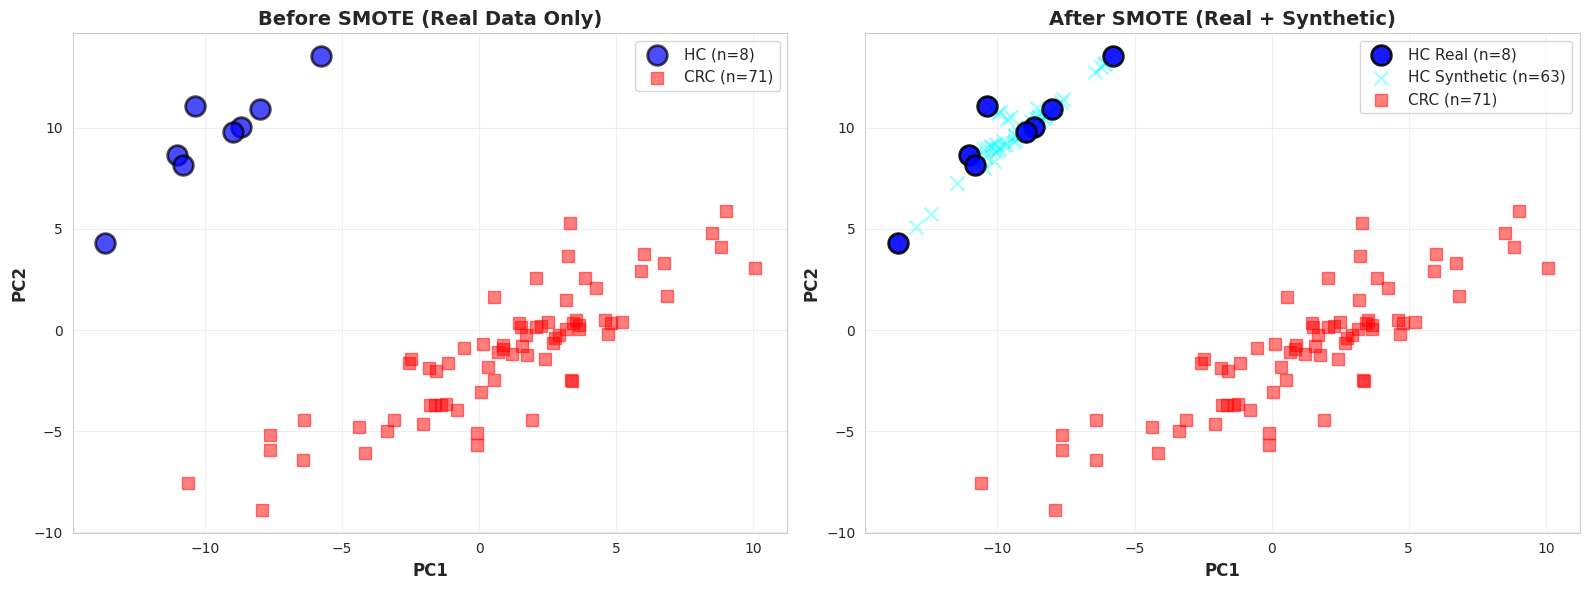

    ✓ SMOTE validation plot saved to: smote_validation_fold1.png

    PCA explained variance:
      PC1: 23.90%
      PC2: 18.11%
      Total: 42.00%

    Synthetic HC quality metrics:
      Mean distance to nearest real HC: 0.5112
      Std distance to nearest real HC:  0.3786
      Max distance to nearest real HC:  1.8824


    Best inner CV AUC: 0.9722
    Train AUC: 1.0000
    Test AUC:  1.0000

  Fold 2 class distribution:
    Train: 70/79 (88.61%) CRC
    Test:  18/20 (90.00%) CRC

    [Fold 2] Feature selection on training data only
      Train samples: 79 (9 HC, 70 CRC)
      Total probes: 15739
      Stage 1: 1533 probes (|log2FC| > 0.585, p < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 12 features
        SVM-RFE: 150 features
        Random Forest: 200 features
      Stage 3: 69 features (≥2/3 consensus)

    [Fold 2] Training with 69 features
    Best inner CV AUC: 1.0000
    Train AUC: 1.0000
    Test AUC:  1.0000

  Fold 3 class distribution:
    Train: 70/79 (88.61%) CRC
    Test:  18/20 (90.00%) CRC

    [Fold 3] Feature selection on training data only
      Train samples: 79 (9 HC, 70 CRC)
      Total probes: 15739
      Stage 1: 1537 probes (|log2FC| > 0.585, p < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 141 features
        SVM-RFE: 150 features
        Random Forest: 200 features
      Stage 3: 109 features (≥2/3 consensus)

    [Fold 3] Training with 109 features
    Best inner CV AUC: 0.9952
    Train AUC: 1.0000
    Test AUC:  0.9444

  Fold 4 class distribution:
    Train: 70/79 (88.61%) CRC
    Test:  18/20 (90.00%) CRC

    [Fold 4] Feature selection on training data only
      Train samples: 79 (9 HC, 70 CRC)
      Total probes: 15739
      Stage 1: 1426 probes (|log2FC| > 0.585, p < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 1 features
        SVM-RFE: 150 features
        Random Forest: 200 features
      Stage 3: 56 features (≥2/3 consensus)

    [Fold 4] Training with 56 features
    Best inner CV AUC: 1.0000
    Train AUC: 1.0000
    Test AUC:  0.9722

  Fold 5 class distribution:
    Train: 71/80 (88.75%) CRC
    Test:  17/19 (89.47%) CRC

    [Fold 5] Feature selection on training data only
      Train samples: 80 (9 HC, 71 CRC)
      Total probes: 15739
      Stage 1: 1651 probes (|log2FC| > 0.585, p < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 57 features
        SVM-RFE: 150 features
        Random Forest: 200 features
      Stage 3: 83 features (≥2/3 consensus)

    [Fold 5] Training with 83 features
    Best inner CV AUC: 1.0000
    Train AUC: 1.0000
    Test AUC:  1.0000

  OUT-OF-FOLD PERFORMANCE (Unbiased Estimate)
    ROC-AUC:           0.9897
    95% CI:            [0.9690, 1.0000]
    Accuracy:          0.9596
    Balanced Accuracy: 0.8182
    Precision:         0.9565
    Sensitivity:       1.0000
    Specificity:       0.6364
    F1-score:          0.9778
    Mean Train AUC:    1.0000
    Mean Test AUC:     0.9833
    Confusion Matrix:
    [[ 7  4]
     [ 0 88]]

  Feature Stability Across 5 Folds:
    Selected 5/5: 19
    Selected 4/5: 10
    Selected 3/5: 21
    Highly stable (≥4/5): 29

--------------------------------------------------------------------------------
Model: RandomForest_Weighted
--------------------------------------------------------------------------------

  Fold 1 class distri

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 114 features
        SVM-RFE: 150 features
        Random Forest: 200 features
      Stage 3: 109 features (≥2/3 consensus)

    [Fold 1] Training with 109 features
    Best inner CV AUC: 0.9931
    Train AUC: 1.0000
    Test AUC:  1.0000

  Fold 2 class distribution:
    Train: 70/79 (88.61%) CRC
    Test:  18/20 (90.00%) CRC

    [Fold 2] Feature selection on training data only
      Train samples: 79 (9 HC, 70 CRC)
      Total probes: 15739
      Stage 1: 1533 probes (|log2FC| > 0.585, p < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 12 features
        SVM-RFE: 150 features
        Random Forest: 200 features
      Stage 3: 69 features (≥2/3 consensus)

    [Fold 2] Training with 69 features
    Best inner CV AUC: 1.0000
    Train AUC: 1.0000
    Test AUC:  1.0000

  Fold 3 class distribution:
    Train: 70/79 (88.61%) CRC
    Test:  18/20 (90.00%) CRC

    [Fold 3] Feature selection on training data only
      Train samples: 79 (9 HC, 70 CRC)
      Total probes: 15739
      Stage 1: 1537 probes (|log2FC| > 0.585, p < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 141 features
        SVM-RFE: 150 features
        Random Forest: 200 features
      Stage 3: 109 features (≥2/3 consensus)

    [Fold 3] Training with 109 features
    Best inner CV AUC: 0.9952
    Train AUC: 1.0000
    Test AUC:  1.0000

  Fold 4 class distribution:
    Train: 70/79 (88.61%) CRC
    Test:  18/20 (90.00%) CRC

    [Fold 4] Feature selection on training data only
      Train samples: 79 (9 HC, 70 CRC)
      Total probes: 15739
      Stage 1: 1426 probes (|log2FC| > 0.585, p < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 1 features
        SVM-RFE: 150 features
        Random Forest: 200 features
      Stage 3: 56 features (≥2/3 consensus)

    [Fold 4] Training with 56 features
    Best inner CV AUC: 1.0000
    Train AUC: 1.0000
    Test AUC:  0.9722

  Fold 5 class distribution:
    Train: 71/80 (88.75%) CRC
    Test:  17/19 (89.47%) CRC

    [Fold 5] Feature selection on training data only
      Train samples: 80 (9 HC, 71 CRC)
      Total probes: 15739
      Stage 1: 1651 probes (|log2FC| > 0.585, p < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 57 features
        SVM-RFE: 150 features
        Random Forest: 200 features
      Stage 3: 83 features (≥2/3 consensus)

    [Fold 5] Training with 83 features
    Best inner CV AUC: 1.0000
    Train AUC: 1.0000
    Test AUC:  1.0000

  OUT-OF-FOLD PERFORMANCE (Unbiased Estimate)
    ROC-AUC:           0.9907
    95% CI:            [0.9720, 1.0000]
    Accuracy:          0.9293
    Balanced Accuracy: 0.6818
    Precision:         0.9263
    Sensitivity:       1.0000
    Specificity:       0.3636
    F1-score:          0.9617
    Mean Train AUC:    1.0000
    Mean Test AUC:     0.9944
    Confusion Matrix:
    [[ 4  7]
     [ 0 88]]

  Feature Stability Across 5 Folds:
    Selected 5/5: 19
    Selected 4/5: 10
    Selected 3/5: 21
    Highly stable (≥4/5): 29

--------------------------------------------------------------------------------
Model: SVM
--------------------------------------------------------------------------------

  Fold 1 class distribution:
    Train:

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 114 features
        SVM-RFE: 150 features
        Random Forest: 200 features
      Stage 3: 109 features (≥2/3 consensus)

    [Fold 1] Training with 109 features
    Best inner CV AUC: 1.0000
    Train AUC: 1.0000
    Test AUC:  0.9804

  Fold 2 class distribution:
    Train: 70/79 (88.61%) CRC
    Test:  18/20 (90.00%) CRC

    [Fold 2] Feature selection on training data only
      Train samples: 79 (9 HC, 70 CRC)
      Total probes: 15739
      Stage 1: 1533 probes (|log2FC| > 0.585, p < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 12 features
        SVM-RFE: 150 features
        Random Forest: 200 features
      Stage 3: 69 features (≥2/3 consensus)

    [Fold 2] Training with 69 features
    Best inner CV AUC: 1.0000
    Train AUC: 1.0000
    Test AUC:  1.0000

  Fold 3 class distribution:
    Train: 70/79 (88.61%) CRC
    Test:  18/20 (90.00%) CRC

    [Fold 3] Feature selection on training data only
      Train samples: 79 (9 HC, 70 CRC)
      Total probes: 15739
      Stage 1: 1537 probes (|log2FC| > 0.585, p < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 141 features
        SVM-RFE: 150 features
        Random Forest: 200 features
      Stage 3: 109 features (≥2/3 consensus)

    [Fold 3] Training with 109 features
    Best inner CV AUC: 1.0000
    Train AUC: 1.0000
    Test AUC:  1.0000

  Fold 4 class distribution:
    Train: 70/79 (88.61%) CRC
    Test:  18/20 (90.00%) CRC

    [Fold 4] Feature selection on training data only
      Train samples: 79 (9 HC, 70 CRC)
      Total probes: 15739
      Stage 1: 1426 probes (|log2FC| > 0.585, p < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 1 features
        SVM-RFE: 150 features
        Random Forest: 200 features
      Stage 3: 56 features (≥2/3 consensus)

    [Fold 4] Training with 56 features
    Best inner CV AUC: 1.0000
    Train AUC: 1.0000
    Test AUC:  1.0000

  Fold 5 class distribution:
    Train: 71/80 (88.75%) CRC
    Test:  17/19 (89.47%) CRC

    [Fold 5] Feature selection on training data only
      Train samples: 80 (9 HC, 71 CRC)
      Total probes: 15739
      Stage 1: 1651 probes (|log2FC| > 0.585, p < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 57 features
        SVM-RFE: 150 features
        Random Forest: 200 features
      Stage 3: 83 features (≥2/3 consensus)

    [Fold 5] Training with 83 features
    Best inner CV AUC: 1.0000
    Train AUC: 1.0000
    Test AUC:  1.0000

  OUT-OF-FOLD PERFORMANCE (Unbiased Estimate)
    ROC-AUC:           0.9917
    95% CI:            [0.9664, 1.0000]
    Accuracy:          0.9798
    Balanced Accuracy: 0.9091
    Precision:         0.9778
    Sensitivity:       1.0000
    Specificity:       0.8182
    F1-score:          0.9888
    Mean Train AUC:    1.0000
    Mean Test AUC:     0.9961
    Confusion Matrix:
    [[ 9  2]
     [ 0 88]]

  Feature Stability Across 5 Folds:
    Selected 5/5: 19
    Selected 4/5: 10
    Selected 3/5: 21
    Highly stable (≥4/5): 29

--------------------------------------------------------------------------------
Model: LogisticRegression
--------------------------------------------------------------------------------

  Fold 1 class distribut

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 114 features
        SVM-RFE: 150 features
        Random Forest: 200 features
      Stage 3: 109 features (≥2/3 consensus)

    [Fold 1] Training with 109 features
    Best inner CV AUC: 1.0000
    Train AUC: 1.0000
    Test AUC:  1.0000

  Fold 2 class distribution:
    Train: 70/79 (88.61%) CRC
    Test:  18/20 (90.00%) CRC

    [Fold 2] Feature selection on training data only
      Train samples: 79 (9 HC, 70 CRC)
      Total probes: 15739
      Stage 1: 1533 probes (|log2FC| > 0.585, p < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 12 features
        SVM-RFE: 150 features
        Random Forest: 200 features
      Stage 3: 69 features (≥2/3 consensus)

    [Fold 2] Training with 69 features
    Best inner CV AUC: 1.0000
    Train AUC: 1.0000
    Test AUC:  1.0000

  Fold 3 class distribution:
    Train: 70/79 (88.61%) CRC
    Test:  18/20 (90.00%) CRC

    [Fold 3] Feature selection on training data only
      Train samples: 79 (9 HC, 70 CRC)
      Total probes: 15739
      Stage 1: 1537 probes (|log2FC| > 0.585, p < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 141 features
        SVM-RFE: 150 features
        Random Forest: 200 features
      Stage 3: 109 features (≥2/3 consensus)

    [Fold 3] Training with 109 features
    Best inner CV AUC: 1.0000
    Train AUC: 1.0000
    Test AUC:  1.0000

  Fold 4 class distribution:
    Train: 70/79 (88.61%) CRC
    Test:  18/20 (90.00%) CRC

    [Fold 4] Feature selection on training data only
      Train samples: 79 (9 HC, 70 CRC)
      Total probes: 15739
      Stage 1: 1426 probes (|log2FC| > 0.585, p < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 1 features
        SVM-RFE: 150 features
        Random Forest: 200 features
      Stage 3: 56 features (≥2/3 consensus)

    [Fold 4] Training with 56 features
    Best inner CV AUC: 1.0000
    Train AUC: 1.0000
    Test AUC:  1.0000

  Fold 5 class distribution:
    Train: 71/80 (88.75%) CRC
    Test:  17/19 (89.47%) CRC

    [Fold 5] Feature selection on training data only
      Train samples: 80 (9 HC, 71 CRC)
      Total probes: 15739
      Stage 1: 1651 probes (|log2FC| > 0.585, p < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 57 features
        SVM-RFE: 150 features
        Random Forest: 200 features
      Stage 3: 83 features (≥2/3 consensus)

    [Fold 5] Training with 83 features
    Best inner CV AUC: 1.0000
    Train AUC: 1.0000
    Test AUC:  1.0000

  OUT-OF-FOLD PERFORMANCE (Unbiased Estimate)
    ROC-AUC:           0.9969
    95% CI:            [0.9860, 1.0000]
    Accuracy:          0.9899
    Balanced Accuracy: 0.9545
    Precision:         0.9888
    Sensitivity:       1.0000
    Specificity:       0.9091
    F1-score:          0.9944
    Mean Train AUC:    1.0000
    Mean Test AUC:     1.0000
    Confusion Matrix:
    [[10  1]
     [ 0 88]]

  Feature Stability Across 5 Folds:
    Selected 5/5: 19
    Selected 4/5: 10
    Selected 3/5: 21
    Highly stable (≥4/5): 29

STEP 5: Model Selection Summary

All Models (ranked by OOF AUC):
  LogisticRegression       : AUC = 0.9969 (95% CI [0.9860, 1.0000])
  SVM                      : AUC = 0.9917 (95% CI [0.9664, 1.0000])
  RandomFore

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 157 features
        SVM-RFE: 150 features
        Random Forest: 200 features
      Stage 3: 115 features (≥2/3 consensus)

[INFO] Selected 115 features from full dataset

Final Model Configuration:
  Model type: LogisticRegression
  Features: 115
  Hyperparameters:
    clf__C: 0.1
    clf__penalty: l2
    clf__solver: lbfgs

[INFO] Variables ready for downstream analysis:
  - best_full_model: Trained classifier
  - feature_cols: Selected feature list (115 probes)
  - X: Normalized feature matrix ((99, 115))
  - y: Binary labels (99)

STEP 7: Save Results and Visualizations
[INFO] Results saved to: /content/drive/MyDrive/geoexosome_results/nested_cv_results.json
[INFO] Feature stability tables saved for all models
[INFO] ROC curves saved to: /content/drive/MyDrive/geoexosome_results/roc_curves_nested_cv.png

✓ NESTED CROSS-VALIDATION COMPLETE

Best model: LogisticRegression
Unbiased OOF AUC: 0.9969
95% CI: [0.9860, 1.0000]

Results saved to: /content/drive/MyDrive/geoex

In [10]:
# ==============================================================================
# Cell 2: Nested Cross-Validation with Fold-wise Feature Selection
# ==============================================================================
"""
Purpose:
    Rigorous nested cross-validation (5-fold outer, 3-fold inner) with
    independent feature selection within each training fold to prevent
    information leakage and ensure unbiased performance estimation.

Methodology:
    1. Outer CV (5-fold): Unbiased performance estimation
    2. Inner CV (3-fold): Hyperparameter tuning
    3. Fold-wise feature selection: Independent selection per fold
    4. Train-only normalization: Test data never influences preprocessing

Models Compared:
    - Random Forest with SMOTE
    - Random Forest with class weighting
    - Support Vector Machine with SMOTE
    - Logistic Regression with SMOTE

Feature Selection Strategy (per fold):
    Stage 1: Biological filtering (fold change + Mann-Whitney U test)
    Stage 2: Multi-method consensus (LASSO, SVM-RFE, Random Forest)
    Stage 3: 2-of-3 consensus voting

Outputs:
    1. Out-of-fold (OOF) performance metrics with 95% CI
    2. Feature stability analysis across folds
    3. Final model trained on full dataset for external validation
    4. Comprehensive results JSON and visualization

Author: Jungho Sohn
Date: 2025-12-20
Version: 2.0 (Data leakage eliminated)
"""

import json
import warnings
import numpy as np
import pandas as pd
from collections import Counter
from scipy import stats
from scipy.stats import mannwhitneyu

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    balanced_accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.feature_selection import RFE

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore', category=FutureWarning)

print("""
=====================================================================
Cell 4: Nested Cross-Validation with Fold-wise Feature Selection

Strategy:
  - 5-fold outer CV for unbiased performance estimation
  - 3-fold inner CV for hyperparameter tuning
  - INDEPENDENT feature selection within each training fold
  - NO information leakage from test folds

This provides rigorous, unbiased estimates of model generalization
suitable for publication in peer-reviewed journals.
=====================================================================
""")

# ==============================================================================
# 1. Load Expression Data from Cell 1 (NO Normalization Applied!)
# ==============================================================================
print("\n" + "=" * 80)
print("STEP 1: Load Expression Data from Cell 1")
print("=" * 80)

# Extract raw expression matrix (should be log2-transformed, NO quantile norm!)
expr_raw = df_expression.drop(columns=['label'])
labels_full = df_expression['label'].values
sample_ids_full = df_expression.index.tolist()

# Apply log2 transformation if not already done
if expr_raw.values.max() > 20:
    print("[INFO] Applying log2(x + 1) transformation to raw expression values")
    expr_log_full = np.log2(expr_raw + 1.0)
else:
    print("[INFO] Data appears log2-transformed. Using as-is.")
    expr_log_full = expr_raw.copy()

# Handle infinite values from log2 transformation
expr_log_full = expr_log_full.replace([np.inf, -np.inf], np.nan)
expr_log_full = expr_log_full.fillna(expr_log_full.median(axis=0))

# Convert to DataFrame with proper indices
expr_log_full = pd.DataFrame(
    expr_log_full.values,
    index=sample_ids_full,
    columns=expr_raw.columns
)

print(f"[INFO] Expression matrix loaded: {expr_log_full.shape}")
print(f"  Samples: {len(sample_ids_full)}")
print(f"  Probes: {expr_log_full.shape[1]}")
print(f"  Healthy controls: {sum(labels_full == 0)}")
print(f"  CRC patients: {sum(labels_full == 1)}")
print(f"  Class imbalance ratio: 1:{sum(labels_full == 1)/sum(labels_full == 0):.1f}")

# CRITICAL: Ensure NO normalization has been applied globally
print("\n[VERIFICATION] Checking for data leakage risks:")
print(f"  Max value: {expr_log_full.values.max():.2f}")
print(f"  Min value: {expr_log_full.values.min():.2f}")
print(f"  Global mean: {expr_log_full.values.mean():.2f}")
print(f"  Global std: {expr_log_full.values.std():.2f}")
if abs(expr_log_full.values.mean()) < 0.1 and abs(expr_log_full.values.std() - 1.0) < 0.1:
    print("  ⚠️  WARNING: Data appears globally normalized! Risk of data leakage!")
else:
    print("  ✓ Data is NOT globally normalized. Safe for fold-wise processing.")

# ==============================================================================
# 2. Cross-Validation Configuration
# ==============================================================================
print("\n" + "=" * 80)
print("STEP 2: Configure Cross-Validation Strategy")
print("=" * 80)

# Outer CV: 5-fold stratified for unbiased performance estimation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Inner CV: 3-fold stratified for hyperparameter tuning
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

print(f"[INFO] Outer CV: {outer_cv.get_n_splits()}-fold stratified")
print(f"[INFO] Inner CV: {inner_cv.get_n_splits()}-fold stratified")
print(f"[INFO] Random seed: {SEED}")

# Create results directory
RESULT_DIR = base_save_path
print(f"[INFO] Results will be saved to: {RESULT_DIR}")

# ==============================================================================
# 3. Model Configurations
# ==============================================================================
print("\n" + "=" * 80)
print("STEP 3: Define Model Configurations")
print("=" * 80)

model_configs = {}

# Random Forest with SMOTE oversampling
model_configs["RandomForest_SMOTE"] = {
    "use_smote": True,
    "use_scaler": False,  # RF doesn't require scaling
    "classifier": "rf",
    "param_grid": {
        "clf__n_estimators": [200, 500],
        "clf__max_depth": [None, 5, 10],
        "clf__max_features": [0.3, 0.5, "sqrt"]
    }
}

# Random Forest with class weighting (no SMOTE)
model_configs["RandomForest_Weighted"] = {
    "use_smote": False,
    "use_scaler": False,
    "classifier": "rf",
    "param_grid": {
        "clf__n_estimators": [200, 500],
        "clf__max_depth": [None, 5, 10],
        "clf__max_features": [0.3, 0.5, "sqrt"]
    }
}

# Support Vector Machine with SMOTE
model_configs["SVM"] = {
    "use_smote": True,
    "use_scaler": True,  # SVM requires scaling
    "classifier": "svm",
    "param_grid": {
        "clf__C": [0.1, 1, 10],
        "clf__gamma": ["scale", "auto"]
    }
}

# Logistic Regression with SMOTE
model_configs["LogisticRegression"] = {
    "use_smote": True,
    "use_scaler": True,  # LR benefits from scaling
    "classifier": "lr",
    "param_grid": {
        "clf__C": [0.1, 1, 10],
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs"]
    }
}

print(f"[INFO] Configured {len(model_configs)} model variants:")
for model_name in model_configs.keys():
    print(f"  - {model_name}")

# ==============================================================================
# 4. Utility Functions
# ==============================================================================

def bootstrap_auc_ci(y_true, y_proba, n_bootstrap=1000, alpha=0.05, random_state=SEED):
    """
    Compute bootstrap confidence interval for ROC-AUC.

    Parameters
    ----------
    y_true : array-like
        True binary labels
    y_proba : array-like
        Predicted probabilities for positive class
    n_bootstrap : int, default=1000
        Number of bootstrap iterations
    alpha : float, default=0.05
        Significance level (0.05 for 95% CI)
    random_state : int, default=SEED
        Random seed for reproducibility

    Returns
    -------
    lower : float
        Lower bound of confidence interval
    upper : float
        Upper bound of confidence interval
    """
    rng = np.random.RandomState(random_state)
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)
    n = len(y_true)

    aucs = []
    for _ in range(n_bootstrap):
        # Bootstrap sample with replacement
        indices = rng.choice(n, n, replace=True)

        # Skip if bootstrap sample doesn't contain both classes
        if len(np.unique(y_true[indices])) < 2:
            continue

        aucs.append(roc_auc_score(y_true[indices], y_proba[indices]))

    if len(aucs) == 0:
        return np.nan, np.nan

    # Compute percentile-based confidence interval
    lower = np.percentile(aucs, 100 * (alpha / 2))
    upper = np.percentile(aucs, 100 * (1 - alpha / 2))

    return float(lower), float(upper)


def perform_fold_feature_selection(expr_train, y_train, fold_idx, verbose=True):
    """
    Three-stage feature selection pipeline on training data only.

    CRITICAL: This function operates ONLY on training data to prevent
    information leakage. Test data must never influence feature selection.

    Stage 1: Biological filtering (fold change + Mann-Whitney U test)
        - Criteria: |log2FC| > 0.585 (≈1.5-fold) AND p-value < 0.05
        - Ensures biological significance and statistical validity

    Stage 2: Multi-method consensus (LASSO, SVM-RFE, Random Forest)
        - LASSO: L1 regularization for sparse selection
        - SVM-RFE: Recursive feature elimination with linear SVM
        - Random Forest: Tree-based importance with SMOTE balancing

    Stage 3: 2-of-3 consensus voting
        - Features selected by at least 2 of 3 methods
        - Reduces method-specific bias
        - Increases robustness of biomarker selection

    Parameters
    ----------
    expr_train : pd.DataFrame
        Training expression data (samples × probes)
    y_train : array-like
        Training labels (0=healthy, 1=cancer)
    fold_idx : int or str
        Current fold index for logging
    verbose : bool, default=True
        Whether to print progress information

    Returns
    -------
    selected_features : list
        Probe IDs selected by consensus
    feature_info : dict
        Detailed statistics about feature selection process
    """
    if verbose:
        print(f"\n    [Fold {fold_idx}] Feature selection on training data only")
        print(f"      Train samples: {len(expr_train)} ({sum(y_train==0)} HC, {sum(y_train==1)} CRC)")
        print(f"      Total probes: {expr_train.shape[1]}")

    # Separate control and cancer samples
    expr_control = expr_train[y_train == 0]
    expr_cancer = expr_train[y_train == 1]

    # -------------------------------------------------------------------------
    # Stage 1: Biological Filtering
    # -------------------------------------------------------------------------
    fold_changes = {}
    p_values = {}
    log2_fold_changes = {}
    selected_bio = []

    for probe in expr_train.columns:
        control_vals = expr_control[probe].values
        cancer_vals = expr_cancer[probe].values

        control_mean = control_vals.mean()
        cancer_mean = cancer_vals.mean()

        # Compute log2 fold change
        log2fc = cancer_mean - control_mean
        log2_fold_changes[probe] = log2fc
        fold_changes[probe] = 2 ** log2fc

        # Mann-Whitney U test (non-parametric, robust to outliers)
        try:
            _, pval = mannwhitneyu(control_vals, cancer_vals, alternative='two-sided')
            p_values[probe] = pval
        except:
            p_values[probe] = 1.0

        # Apply biological significance thresholds
        if abs(log2fc) > 1.0 and pval < 0.001:
            selected_bio.append(probe)

    if verbose:
        print(f"      Stage 1: {len(selected_bio)} probes (|log2FC| > 0.585, p < 0.05)")

    # Relax criteria if insufficient features
    if len(selected_bio) < 100:
        if verbose:
            print(f"      Relaxing to |log2FC| > 0.5, p < 0.1...")
        selected_bio = []
        for probe in expr_train.columns:
            if abs(log2_fold_changes[probe]) > 0.5 and p_values[probe] < 0.1:
                selected_bio.append(probe)
        if verbose:
            print(f"      Relaxed Stage 1: {len(selected_bio)} probes")

    # Safety backup: variance-based selection if still insufficient
    if len(selected_bio) < 50:
        probe_var = expr_train.var(axis=0)
        selected_bio = probe_var.nlargest(min(1000, len(expr_train.columns))).index.tolist()
        if verbose:
            print(f"      Using variance backup: {len(selected_bio)} probes")

    # -------------------------------------------------------------------------
    # Stage 2: Multi-method Consensus
    # -------------------------------------------------------------------------
    if verbose:
        print(f"      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)")

    X_bio = expr_train[selected_bio].values

    # Standardize for methods that require it (LASSO, SVM-RFE)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_bio)

    # ─────────────────────────────────────────────────────────────────────────
    # Method A: LASSO Regularization
    # ─────────────────────────────────────────────────────────────────────────
    try:
        lasso = LassoCV(
            cv=3,
            random_state=SEED,
            max_iter=20000,
            n_jobs=-1,
            tol=1e-3
        )
        lasso.fit(X_scaled, y_train)

        # Select features with non-zero coefficients
        lasso_feat = [selected_bio[i] for i, c in enumerate(lasso.coef_) if c != 0]

        # Fallback: select top features by coefficient magnitude if none selected
        if len(lasso_feat) == 0:
            lasso_coef_abs = np.abs(lasso.coef_)
            top_idx = np.argsort(lasso_coef_abs)[-200:]
            lasso_feat = [selected_bio[i] for i in top_idx]

        if verbose:
            print(f"        LASSO: {len(lasso_feat)} features")

    except Exception as e:
        if verbose:
            print(f"        LASSO failed ({str(e)}), using variance fallback")
        var_bio = expr_train[selected_bio].var(axis=0)
        lasso_feat = var_bio.nlargest(min(200, len(selected_bio))).index.tolist()

    # ─────────────────────────────────────────────────────────────────────────
    # Method B: SVM-RFE (Recursive Feature Elimination)
    # ─────────────────────────────────────────────────────────────────────────
    try:
        n_features_target = min(150, len(selected_bio) // 3)

        svc = SVC(kernel='linear', class_weight='balanced', random_state=SEED)
        rfe = RFE(
            estimator=svc,
            n_features_to_select=n_features_target,
            step=10,
            verbose=0
        )
        rfe.fit(X_scaled, y_train)

        svm_rfe_feat = [selected_bio[i] for i in np.where(rfe.support_)[0]]

        if verbose:
            print(f"        SVM-RFE: {len(svm_rfe_feat)} features")

    except Exception as e:
        if verbose:
            print(f"        SVM-RFE failed ({str(e)}), using variance fallback")
        var_bio = expr_train[selected_bio].var(axis=0)
        svm_rfe_feat = var_bio.nlargest(min(150, len(selected_bio))).index.tolist()

    # ─────────────────────────────────────────────────────────────────────────
    # Method C: Random Forest Feature Importance
    # ─────────────────────────────────────────────────────────────────────────
    try:
        # Apply SMOTE to balance training data
        k_neighbors = min(3, sum(y_train == 0) - 1)
        if k_neighbors < 1:
            k_neighbors = 1

        smote = SMOTE(random_state=SEED, k_neighbors=k_neighbors)
        X_smoted, y_smoted = smote.fit_resample(X_bio, y_train)

        rf = RandomForestClassifier(
            n_estimators=200,
            random_state=SEED,
            n_jobs=-1,
            class_weight='balanced_subsample'
        )
        rf.fit(X_smoted, y_smoted)

        # Select top features by importance
        importances = rf.feature_importances_
        n_rf = min(200, len(selected_bio))
        top_idx = np.argsort(importances)[-n_rf:]
        rf_feat = [selected_bio[i] for i in top_idx]

        if verbose:
            print(f"        Random Forest: {len(rf_feat)} features")

    except Exception as e:
        if verbose:
            print(f"        Random Forest failed ({str(e)}), using variance fallback")
        var_bio = expr_train[selected_bio].var(axis=0)
        rf_feat = var_bio.nlargest(min(200, len(selected_bio))).index.tolist()

    # ─────────────────────────────────────────────────────────────────────────
    # Stage 3: Consensus Voting (2-of-3)
    # ─────────────────────────────────────────────────────────────────────────
    feature_votes = Counter()
    for feat_set in [set(lasso_feat), set(svm_rfe_feat), set(rf_feat)]:
        feature_votes.update(feat_set)

    # Select features appearing in at least 2 methods
    selected_consensus = [f for f, count in feature_votes.items() if count >= 2]

    if verbose:
        print(f"      Stage 3: {len(selected_consensus)} features (≥2/3 consensus)")

    # Ensure minimum feature count for stable model training
    if len(selected_consensus) < 20:
        sorted_features = sorted(feature_votes.items(), key=lambda x: x[1], reverse=True)
        selected_consensus = [f for f, _ in sorted_features[:max(20, len(sorted_features))]]
        if verbose:
            print(f"      Adjusted to {len(selected_consensus)} features (minimum threshold)")

    # Compile feature selection statistics
    feature_info = {
        'n_stage1': len(selected_bio),
        'n_lasso': len(lasso_feat),
        'n_svm_rfe': len(svm_rfe_feat),
        'n_rf': len(rf_feat),
        'n_consensus': len(selected_consensus),
        'fold_changes': {k: float(v) for k, v in fold_changes.items() if k in selected_consensus},
        'p_values': {k: float(v) for k, v in p_values.items() if k in selected_consensus}
    }

    return selected_consensus, feature_info


def create_pipeline(config, n_features):
    """
    Construct sklearn/imblearn pipeline based on model configuration.

    Pipeline components are added conditionally based on model requirements:
    - SMOTE: For class imbalance handling (optional)
    - StandardScaler: For feature normalization (optional)
    - Classifier: Final estimator (required)

    Parameters
    ----------
    config : dict
        Model configuration dictionary with keys:
        - use_smote: bool
        - use_scaler: bool
        - classifier: str ('rf', 'svm', or 'lr')
        - param_grid: dict of hyperparameter ranges
    n_features : int
        Number of features (for SMOTE k_neighbors validation)

    Returns
    -------
    pipeline : imblearn.pipeline.Pipeline
        Configured pipeline
    param_grid : dict
        Grid search parameter space
    """
    steps = []

    # Add SMOTE if requested (must be first in pipeline)
    if config["use_smote"]:
        steps.append(("smote", SMOTE(random_state=SEED, k_neighbors=3)))

    # Add StandardScaler if requested
    if config["use_scaler"]:
        steps.append(("scaler", StandardScaler()))

    # Add classifier (always last in pipeline)
    if config["classifier"] == "rf":
        clf = RandomForestClassifier(
            random_state=SEED,
            n_jobs=-1,
            class_weight="balanced_subsample"
        )
    elif config["classifier"] == "svm":
        clf = SVC(
            probability=True,
            random_state=SEED,
            class_weight="balanced"
        )
    elif config["classifier"] == "lr":
        clf = LogisticRegression(
            max_iter=500,
            random_state=SEED,
            class_weight="balanced"
        )
    else:
        raise ValueError(f"Unknown classifier: {config['classifier']}")

    steps.append(("clf", clf))

    # Create pipeline
    pipeline = ImbPipeline(steps)
    param_grid = config["param_grid"].copy()

    return pipeline, param_grid


# ==============================================================================
# 5. Nested Cross-Validation with Fold-wise Feature Selection
# ==============================================================================
print("\n" + "=" * 80)
print("STEP 4: Execute Nested Cross-Validation")
print("=" * 80)

# Initialize result storage
results = {}
oof_predictions = {}
fold_feature_lists = {}
fold_feature_info = {}

# Iterate through each model configuration
for model_name, model_cfg in model_configs.items():

    print("\n" + "-" * 80)
    print(f"Model: {model_name}")
    print("-" * 80)

    # Initialize out-of-fold (OOF) prediction arrays
    oof_proba = np.zeros_like(labels_full, dtype=float)
    oof_pred = np.zeros_like(labels_full, dtype=int)

    # Track performance across folds
    train_auc_folds = []
    test_auc_folds = []

    fold_feature_lists[model_name] = {}
    fold_feature_info[model_name] = {}

    # ─────────────────────────────────────────────────────────────────────────
    # Outer CV Loop: Iterate through train/test splits
    # ─────────────────────────────────────────────────────────────────────────
    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(expr_log_full, labels_full), start=1):

        # Extract training fold data
        train_sample_ids = [sample_ids_full[i] for i in train_idx]
        expr_train_fold = expr_log_full.loc[train_sample_ids].copy()
        y_train_fold = labels_full[train_idx]

        # Extract test fold data
        test_sample_ids = [sample_ids_full[i] for i in test_idx]
        y_test_fold = labels_full[test_idx]

        # Report class distribution
        train_pos = int(y_train_fold.sum())
        test_pos = int(y_test_fold.sum())
        print(f"\n  Fold {fold_idx} class distribution:")
        print(f"    Train: {train_pos}/{len(y_train_fold)} ({train_pos/len(y_train_fold):.2%}) CRC")
        print(f"    Test:  {test_pos}/{len(y_test_fold)} ({test_pos/len(y_test_fold):.2%}) CRC")

        # ─────────────────────────────────────────────────────────────────────
        # CRITICAL: Feature selection on training fold ONLY
        # ─────────────────────────────────────────────────────────────────────
        selected_features, feat_info = perform_fold_feature_selection(
            expr_train_fold,
            y_train_fold,
            fold_idx,
            verbose=True
        )

        # Store selected features for stability analysis
        fold_feature_lists[model_name][f'fold_{fold_idx}'] = selected_features
        fold_feature_info[model_name][f'fold_{fold_idx}'] = feat_info

        # ─────────────────────────────────────────────────────────────────────
        # CRITICAL: Normalization using training statistics ONLY
        # ─────────────────────────────────────────────────────────────────────
        # Extract selected features (log2 scale, NOT yet normalized)
        X_train_log = expr_train_fold[selected_features].values
        X_test_log = expr_log_full.loc[test_sample_ids][selected_features].values

        # Fit scaler on training data ONLY
        scaler_fold = StandardScaler()
        X_train_norm = scaler_fold.fit_transform(X_train_log)

        # Transform test data using training statistics (NO fit!)
        X_test_norm = scaler_fold.transform(X_test_log)

        print(f"\n    [Fold {fold_idx}] Training with {len(selected_features)} features")

        # ─────────────────────────────────────────────────────────────────────
        # Inner CV: Hyperparameter tuning via Grid Search
        # ─────────────────────────────────────────────────────────────────────
        pipeline, param_grid = create_pipeline(model_cfg, len(selected_features))

        gs = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            scoring="roc_auc",
            cv=inner_cv,
            n_jobs=-1,
            refit=True,
            verbose=0
        )

        # Train model with hyperparameter optimization
        gs.fit(X_train_norm, y_train_fold)

        # ─────────────────────────────────────────────────────────────────────
        # Evaluate on training set (for overfitting detection)
        # ─────────────────────────────────────────────────────────────────────
        train_proba = gs.predict_proba(X_train_norm)[:, 1]
        train_auc = roc_auc_score(y_train_fold, train_proba)
        train_auc_folds.append(train_auc)

        # ─────────────────────────────────────────────────────────────────────
        # Evaluate on test set (unbiased performance)
        # ─────────────────────────────────────────────────────────────────────
        test_proba = gs.predict_proba(X_test_norm)[:, 1]
        test_pred = (test_proba >= 0.5).astype(int)

        test_auc = roc_auc_score(y_test_fold, test_proba)
        test_auc_folds.append(test_auc)

        # Store out-of-fold predictions for final aggregation
        oof_proba[test_idx] = test_proba
        oof_pred[test_idx] = test_pred

        # Report fold performance
        print(f"    Best inner CV AUC: {gs.best_score_:.4f}")
        print(f"    Train AUC: {train_auc:.4f}")
        print(f"    Test AUC:  {test_auc:.4f}")

        # Warn if significant overfitting detected
        if train_auc - test_auc > 0.15:
            print(f"    ⚠️  WARNING: Potential overfitting (gap = {train_auc - test_auc:.4f})")

    # ─────────────────────────────────────────────────────────────────────────
    # Aggregate Out-of-Fold Performance Metrics
    # ─────────────────────────────────────────────────────────────────────────
    cm = confusion_matrix(labels_full, oof_pred)
    auc = roc_auc_score(labels_full, oof_proba)
    acc = accuracy_score(labels_full, oof_pred)
    bal_acc = balanced_accuracy_score(labels_full, oof_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels_full, oof_pred, average="binary", zero_division=0
    )

    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    sensitivity = recall

    # Compute 95% confidence interval via bootstrap
    ci_lower, ci_upper = bootstrap_auc_ci(
        labels_full, oof_proba, n_bootstrap=1000, alpha=0.05
    )

    train_auc_mean = float(np.mean(train_auc_folds))
    test_auc_mean = float(np.mean(test_auc_folds))

    # Report aggregated performance
    print("\n  " + "=" * 76)
    print("  OUT-OF-FOLD PERFORMANCE (Unbiased Estimate)")
    print("  " + "=" * 76)
    print(f"    ROC-AUC:           {auc:.4f}")
    print(f"    95% CI:            [{ci_lower:.4f}, {ci_upper:.4f}]")
    print(f"    Accuracy:          {acc:.4f}")
    print(f"    Balanced Accuracy: {bal_acc:.4f}")
    print(f"    Precision:         {precision:.4f}")
    print(f"    Sensitivity:       {sensitivity:.4f}")
    print(f"    Specificity:       {specificity:.4f}")
    print(f"    F1-score:          {f1:.4f}")
    print(f"    Mean Train AUC:    {train_auc_mean:.4f}")
    print(f"    Mean Test AUC:     {test_auc_mean:.4f}")
    print("    Confusion Matrix:")
    print("    " + str(cm).replace('\n', '\n    '))

    # ─────────────────────────────────────────────────────────────────────────
    # Feature Stability Analysis
    # ─────────────────────────────────────────────────────────────────────────
    feature_frequency = Counter()
    for features in fold_feature_lists[model_name].values():
        feature_frequency.update(features)

    n_folds = len(fold_feature_lists[model_name])
    highly_stable = [f for f, count in feature_frequency.items() if count >= 4]

    print(f"\n  Feature Stability Across {n_folds} Folds:")
    print(f"    Selected 5/5: {sum(1 for c in feature_frequency.values() if c == 5)}")
    print(f"    Selected 4/5: {sum(1 for c in feature_frequency.values() if c == 4)}")
    print(f"    Selected 3/5: {sum(1 for c in feature_frequency.values() if c == 3)}")
    print(f"    Highly stable (≥4/5): {len(highly_stable)}")

    # Store comprehensive results
    results[model_name] = {
        "oof_auc": float(auc),
        "oof_auc_ci": [ci_lower, ci_upper],
        "oof_accuracy": float(acc),
        "oof_balanced_accuracy": float(bal_acc),
        "precision": float(precision),
        "recall_sensitivity": float(sensitivity),
        "specificity": float(specificity),
        "f1_score": float(f1),
        "confusion_matrix": cm.tolist(),
        "train_auc_mean": train_auc_mean,
        "train_auc_std": float(np.std(train_auc_folds)),
        "test_auc_mean": test_auc_mean,
        "test_auc_std": float(np.std(test_auc_folds)),
        "feature_stability": {
            "n_folds": n_folds,
            "n_highly_stable": len(highly_stable),
            "highly_stable_features": highly_stable,
            "feature_frequency": {str(k): int(v) for k, v in feature_frequency.most_common(50)}
        }
    }

    oof_predictions[model_name] = {
        "y_true": labels_full.copy(),
        "y_proba": oof_proba.copy(),
        "y_pred": oof_pred.copy()
    }

# ==============================================================================
# 6. Model Selection and Comparison
# ==============================================================================
print("\n" + "=" * 80)
print("STEP 5: Model Selection Summary")
print("=" * 80)

# Select best model by OOF AUC
best_name = max(results, key=lambda k: results[k]["oof_auc"])

print("\nAll Models (ranked by OOF AUC):")
for m_name in sorted(results, key=lambda k: results[k]["oof_auc"], reverse=True):
    res = results[m_name]
    print(f"  {m_name:25s}: AUC = {res['oof_auc']:.4f} "
          f"(95% CI [{res['oof_auc_ci'][0]:.4f}, {res['oof_auc_ci'][1]:.4f}])")

print(f"\n{'=' * 80}")
print(f"BEST MODEL: {best_name}")
print(f"{'=' * 80}")
print(f"  Out-of-fold AUC:       {results[best_name]['oof_auc']:.4f}")
print(f"  95% Confidence Interval: [{results[best_name]['oof_auc_ci'][0]:.4f}, "
      f"{results[best_name]['oof_auc_ci'][1]:.4f}]")
print(f"  Accuracy:              {results[best_name]['oof_accuracy']:.4f}")
print(f"  Balanced Accuracy:     {results[best_name]['oof_balanced_accuracy']:.4f}")
print(f"  Sensitivity:           {results[best_name]['recall_sensitivity']:.4f}")
print(f"  Specificity:           {results[best_name]['specificity']:.4f}")

# ==============================================================================
# 7. Final Model Training on Full Dataset
# ==============================================================================
print("\n" + "=" * 80)
print("STEP 6: Train Final Model on Full Dataset")
print("=" * 80)
print("\n[NOTE] Performance metrics reported above are from nested CV.")
print("        This final model is for:")
print("        1. Biological interpretation (feature importance, SHAP)")
print("        2. External validation on independent datasets")
print("        3. Future clinical deployment")

# Perform feature selection on full dataset
print("\n[INFO] Performing feature selection on full dataset...")
expr_full_df = pd.DataFrame(
    expr_log_full.values,
    index=sample_ids_full,
    columns=expr_log_full.columns
)

final_features, final_feat_info = perform_fold_feature_selection(
    expr_full_df,
    labels_full,
    fold_idx="FULL",
    verbose=True
)

print(f"\n[INFO] Selected {len(final_features)} features from full dataset")

# Extract and normalize selected features
X_final_log = expr_full_df[final_features].values
scaler_final = StandardScaler()
X_final = scaler_final.fit_transform(X_final_log)

# Store for downstream analysis
feature_cols = final_features
X = X_final
y = labels_full

# Train final model with hyperparameter optimization
best_cfg = model_configs[best_name]
final_pipeline, final_param_grid = create_pipeline(best_cfg, len(final_features))

final_model = GridSearchCV(
    estimator=final_pipeline,
    param_grid=final_param_grid,
    scoring="roc_auc",
    cv=inner_cv,
    n_jobs=-1,
    refit=True,
    verbose=0
)

final_model.fit(X_final, labels_full)

# Store best model and parameters
best_full_model = final_model.best_estimator_
best_full_params = final_model.best_params_

results[best_name]["best_estimator"] = best_full_model
results[best_name]["best_params"] = best_full_params

print(f"\nFinal Model Configuration:")
print(f"  Model type: {best_name}")
print(f"  Features: {len(feature_cols)}")
print(f"  Hyperparameters:")
for k, v in best_full_params.items():
    print(f"    {k}: {v}")

print(f"\n[INFO] Variables ready for downstream analysis:")
print(f"  - best_full_model: Trained classifier")
print(f"  - feature_cols: Selected feature list ({len(feature_cols)} probes)")
print(f"  - X: Normalized feature matrix ({X.shape})")
print(f"  - y: Binary labels ({len(y)})")

# ==============================================================================
# 8. Save Comprehensive Results
# ==============================================================================
print("\n" + "=" * 80)
print("STEP 7: Save Results and Visualizations")
print("=" * 80)

# Save nested CV results as JSON
json_path = os.path.join(RESULT_DIR, "nested_cv_results.json")
with open(json_path, "w", encoding="utf-8") as f:
    # Convert non-serializable objects
    json_results = {}
    for model_name, res in results.items():
        json_results[model_name] = {
            k: v for k, v in res.items()
            if k not in ["best_estimator"]  # Skip non-serializable objects
        }
    json.dump(json_results, f, indent=2, ensure_ascii=False)
print(f"[INFO] Results saved to: {json_path}")

# Save feature stability analysis
for model_name in results:
    feature_freq = results[model_name]["feature_stability"]["feature_frequency"]
    df_stability = pd.DataFrame(
        list(feature_freq.items()),
        columns=["Probe_ID", "Selection_Frequency"]
    ).sort_values("Selection_Frequency", ascending=False)

    stability_path = os.path.join(RESULT_DIR, f"feature_stability_{model_name}.csv")
    df_stability.to_csv(stability_path, index=False)

print(f"[INFO] Feature stability tables saved for all models")

# Generate ROC curve plot
plt.figure(figsize=(8, 6))
for model_name in results:
    y_true = oof_predictions[model_name]["y_true"]
    y_proba = oof_predictions[model_name]["y_proba"]

    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_val = results[model_name]["oof_auc"]
    ci_low, ci_high = results[model_name]["oof_auc_ci"]

    plt.plot(
        fpr, tpr,
        label=f'{model_name}: AUC={auc_val:.3f} [{ci_low:.3f}-{ci_high:.3f}]',
        linewidth=2
    )

plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Out-of-Fold Predictions (Nested CV)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()

roc_path = os.path.join(RESULT_DIR, "roc_curves_nested_cv.png")
plt.savefig(roc_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"[INFO] ROC curves saved to: {roc_path}")

print("\n" + "=" * 80)
print("✓ NESTED CROSS-VALIDATION COMPLETE")
print("=" * 80)
print(f"\nBest model: {best_name}")
print(f"Unbiased OOF AUC: {results[best_name]['oof_auc']:.4f}")
print(f"95% CI: [{results[best_name]['oof_auc_ci'][0]:.4f}, {results[best_name]['oof_auc_ci'][1]:.4f}]")
print(f"\nResults saved to: {RESULT_DIR}")
print("=" * 80 + "\n")